In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt

from mk_dataset.audio_mixer import AudioMixer
from mk_dataset.spectrogram import Spectrogram

from models.unet_v4 import UNet as UNet_v4
from models.unet_torch import UNet as UNet_torch

from infernece_compare import load_custom_weights, convert_audio

In [2]:
# 1. 오디오 파일 로드
audio_wave, audio_rate = torchaudio.load("test2.m4a")

In [3]:
print(audio_wave.shape)
print(audio_rate)

torch.Size([1, 361408])
48000


In [4]:
# 오디오 파일 sampling rate 변환
audiomixer = AudioMixer(sr=16000, target_frame=256, hop_length=160)
audio_wave = audiomixer._preprocess_waveform(audio_wave, audio_rate)
print(audio_wave.shape)

torch.Size([1, 120470])


In [5]:
# 2.55초 구간으로 자르기
SR = 16000
CHUNK_SEC = 2.55
OVERLAP_RATIO = 0.5

chunks = []
total_len = audio_wave.shape[1]
print(total_len)

target_samples = int(SR * CHUNK_SEC)
print(target_samples)

stride = int(target_samples * (1 - OVERLAP_RATIO))
print(stride)

120470
40800
20400


In [6]:
for start in range(0, total_len, stride):
    end = start + target_samples

    chunk = audio_wave[:, start:end]

    # 마지막 chunk가 2.55보다 짧으면 zero padding
    if chunk.shape[1] < target_samples:
        pad_amount = target_samples - chunk.shape[1]
        chunk = torch.nn.functional.pad(chunk, (0, pad_amount))

    chunks.append(chunk)

print(len(chunks))

batch_input = torch.stack(chunks)
print(batch_input.shape)


6
torch.Size([6, 1, 40800])


In [7]:
# 스펙트로그램으로 변환
spec_converter = Spectrogram()

input_spec, input_phase = spec_converter.to_spec(batch_input)
print(input_spec.shape)
print(input_phase.shape)

torch.Size([6, 1, 256, 256])
torch.Size([6, 1, 256, 256])


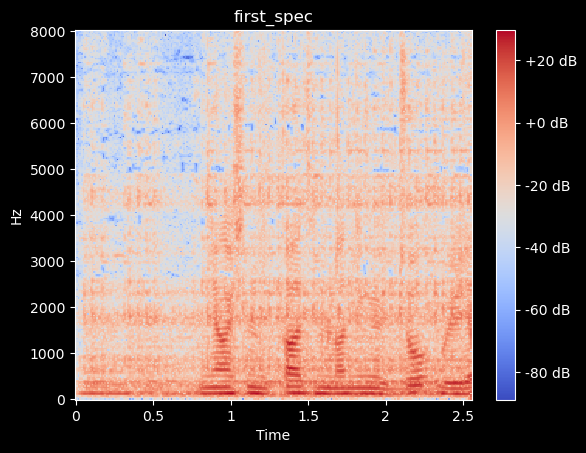

In [8]:
first_spec = input_spec[0]
spec_converter.plot(first_spec, title="first_spec")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [9]:
# 스펙트로그램 정규화
input_spec = torch.clamp(input_spec, min=-80.0, max=0.0)
input_spec = (input_spec - input_spec.min()) / (input_spec.max() - input_spec.min())

In [10]:
CHANNELS = [1, 32 ,64, 128, 256, 512]
CHECKPOINT_PATH_4 = "./checkpoints/v4/last_checkpoint.pth"
CHECKPOINT_PATH_TORCH = "./checkpoints/torch/last.pt"

In [11]:
model_v4 = UNet_v4(CHANNELS, filter_size=3)

model_torch = UNet_torch(CHANNELS)
device = torch.device('cpu')
model_torch.to(device)

# 가중치 로드
load_custom_weights(model_v4, CHECKPOINT_PATH_4)

ckpt_torch = torch.load(CHECKPOINT_PATH_TORCH, map_location=device)
model_torch.load_state_dict(ckpt_torch["model_state_dict"])
model_torch.eval()

가중치 파일 로드 중: ./checkpoints/v4/last_checkpoint.pth
가중치 로드 완료!


/Users/kyuhyeon/coding/dlearn/audio_denoising/infernece_compare.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="c

UNet(
  (enc1): CBR(
    (layer): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): DownSample(
    (layer): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (enc2): CBR(
    (layer): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down2): DownSample(
    (layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inpla

In [12]:
# 추론
denoised_output_v4 = model_v4.forward(input_spec)

with torch.no_grad():
    denoised_output_torch = model_torch(input_spec)

In [13]:
# 텐서를 numpy로 변환
denoised_output_v4 = denoised_output_v4.squeeze().numpy()
denoised_output_torch = denoised_output_torch.squeeze().numpy()
input_phase = input_phase.squeeze().numpy()

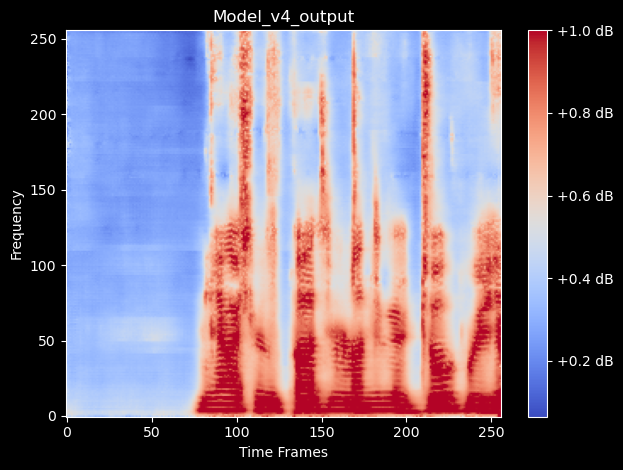

In [14]:
# 시각화
plt.imshow(denoised_output_v4[0], aspect="auto", origin="lower", cmap="coolwarm")
plt.colorbar(format="%+.1f dB")
plt.xlabel("Time Frames")
plt.ylabel("Frequency")
plt.title("Model_v4_output")
plt.tight_layout()
plt.show()

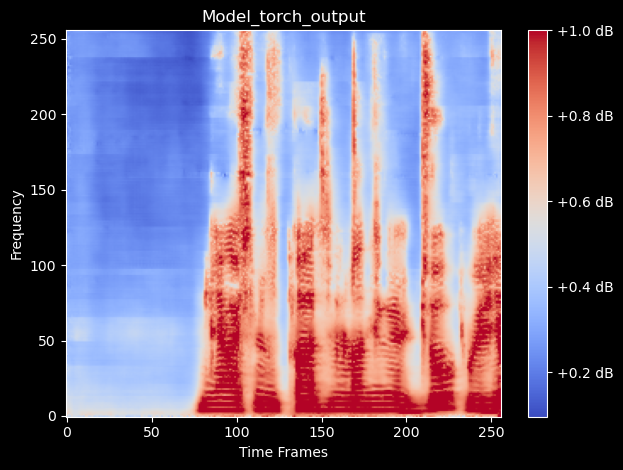

In [15]:
plt.imshow(denoised_output_torch[0], aspect="auto", origin="lower", cmap="coolwarm")
plt.colorbar(format="%+.1f dB")
plt.xlabel("Time Frames")
plt.ylabel("Frequency")
plt.title("Model_torch_output")
plt.tight_layout()
plt.show()

In [16]:
# 오디오로 변환
output_audio_v4 = convert_audio(denoised_output_v4, input_phase)
output_audio_torch = convert_audio(denoised_output_torch, input_phase)

In [17]:
# 이어 붙히기
# 빈 텐서 생성
recon_audio_v4 = torch.zeros(total_len + target_samples)
print(recon_audio_v4[:5])
count_audio_v4 = torch.zeros(total_len + target_samples)

recon_chunks_v4 = output_audio_v4

# 루프 돌며 합치기
curr = 0
for i, chunk in enumerate(recon_chunks_v4):
    # 시작 끝 위치
    start = curr
    end = start + target_samples

    # 시작 끝 위치에 차례대로 삽입
    recon_audio_v4[start:end] += chunk
    count_audio_v4[start:end] += 1

    # 다음 칸으로 이동
    curr += stride

print(count_audio_v4[20400:20405])

# 겹친만큼 나누기
mask = count_audio_v4 > 0.1
recon_audio_v4[mask] = recon_audio_v4[mask] / count_audio_v4[mask]

# padding 제거
final_v4 = recon_audio_v4[: total_len]
print(final_v4.shape)

tensor([0., 0., 0., 0., 0.])
tensor([2., 2., 2., 2., 2.])
torch.Size([120470])


/var/folders/d6/klnztyj51h5d3y23pmnjp7v00000gn/T/ipykernel_32419/538550837.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  recon_audio_v4[start:end] += chunk


In [18]:
# 파일로 저장
import soundfile as sf

output_path = "test2_output_v4.wav"
sf.write(output_path, final_v4, 16000)
print(f"Saved : {output_path}")

Saved : test2_output_v4.wav


In [19]:
# 이어 붙히기
# 빈 텐서 생성
recon_audio_torch = torch.zeros(total_len + target_samples)
print(recon_audio_torch[:5])
count_audio_torch = torch.zeros(total_len + target_samples)

recon_chunks_torch = output_audio_torch

# 루프 돌며 합치기
curr = 0
for i, chunk in enumerate(recon_chunks_torch):
    # 시작 끝 위치
    start = curr
    end = start + target_samples

    # 시작 끝 위치에 차례대로 삽입
    recon_audio_torch[start:end] += chunk
    count_audio_torch[start:end] += 1

    # 다음 칸으로 이동
    curr += stride

print(count_audio_torch[20400:20405])

# 겹친만큼 나누기
mask = count_audio_torch > 0.1
recon_audio_torch[mask] = recon_audio_torch[mask] / count_audio_torch[mask]

# padding 제거
final_torch = recon_audio_torch[: total_len]
print(final_torch.shape)

output_path = "test2_output_torch.wav"
sf.write(output_path, final_torch, 16000)
print(f"Saved : {output_path}")

tensor([0., 0., 0., 0., 0.])
tensor([2., 2., 2., 2., 2.])
torch.Size([120470])
Saved : test2_output_torch.wav


/var/folders/d6/klnztyj51h5d3y23pmnjp7v00000gn/T/ipykernel_32419/2192116922.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  recon_audio_torch[start:end] += chunk
